# Summary

In this project we worked with an open hotel booking dataset containing reservations for both city and resort hotels and we selected a smaller set of features that would realistically be available at the time of booking, such as lead time, whether the guest is a repeat customer, previous cancellations, booking changes, special requests, reserved room type and deposit type. After a brief exploratory analysis, we confirmed that cancellations are fairly common and that patterns differ across hotel types and booking conditions, especially for repeated guests and deposit policies. We then framed the problem as a binary classification task: predict whether a booking will be cancelled or not. The data was split into training and test sets, and we built pipelines that combined preprocessing with three models: K-Nearest Neighbours, a decision tree and an RBF-kernel SVM. 

Using 5-fold cross validation with F1 score on the training set, KNN gave the best performance, so we chose it as our final model and evaluated it on the unseen test data. On the test set, our KNN model performs well enough with an accuracy of 73% and that it could plausibly support day-to-day hotel operations, at least as a first-pass tool for flagging higher-risk bookings. The confusion matrix shows that the model correctly identifies most non-cancellations and captures a reasonable portion of true cancellations, even though it still misses some risky bookings. That said, we do not see it as a finished solution. There is clear value in extending the feature set, tuning the model more carefully, and examining in detail which types of reservations are consistently misclassified. This would not only improve raw performance, but also give hotels a better sense of when to rely on the model’s predictions and when they should be treated as one input alongside staff experience and existing booking policies.

# Introduction

Free cancellations for hotel bookings are increasingly popular nowadays, but cancellations create significant impact on a hotel's revenue and operation. Predicting whether a reservation will be canceled can help hotels manage resources more effectively, reduce lost revenue, and improve customer service.


In our project, we aim to answer the question "can we build a model that accurately predicts whether a hotel booking will be canceled?" This will be a binary classification problem, where each booking is labeled as either “canceled” or “not canceled”.


To explore this, we used a publicly available dataset from GitHub (https://github.com/JulKelman/Predicting-Hotel-Bookings-Cancellation). The dataset contains information about hotel reservations, and the label column is called "IsCanceled", which indicates whether a booking was canceled or not. One of the important features is "Lead Time", showing how many days passed between the booking date and the arrival date. Some other important features include deposit type, number of adults, arrival year and month, which are all helpful for our classification model.

# Discussion

-- Content to add here ---

# Data Summary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.loads data from the original source on the web
def load_data(url: str) -> pd.DataFrame:
    """Load dataset from a given URL."""
    return pd.read_csv(url)

# 2. wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean dataset: remove duplicates, handle missing values."""
    df = df.drop_duplicates()

    # Handle missing values
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
    df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

    return df

url = "https://github.com/manthangandhi/hotel_cancellation_prediction/raw/refs/heads/main/data/hotel_bookings.csv"
df = load_data(url)
df_clean = clean_data(df)

/var/folders/rv/7txrlwz97ln_0fl__lh05xbm0000gv/T/ipykernel_15498/210987562.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
/var/folders/rv/7txrlwz97ln_0fl__lh05xbm0000gv/T/ipykernel_15498/210987562.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


In [3]:
# 3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
def summarize_data(df: pd.DataFrame) -> None:
    """Print summary of dataset for EDA."""
    print("\n=== Dataset Summary ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Target Variable Distribution (is_canceled) ---")
    print(df['is_canceled'].value_counts(normalize=True).rename("proportion").to_frame())

    print("\n--- Numerical Features Summary ---")
    print(df.describe().T[['mean', 'std', 'min', 'max']])

    print("\n--- Categorical Features Summary ---")
    print(df.describe(include='object').T[['unique', 'top', 'freq']])

    print("\n--- Missing Values After Cleaning ---")
    print(pd.DataFrame({"Metric": ["Total Missing"], "Count": [df.isnull().sum().sum()]}))

summarize_data(df_clean)



=== Dataset Summary ===
Shape: 87396 rows × 32 columns

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87396 non-null  float64
 11  babies           

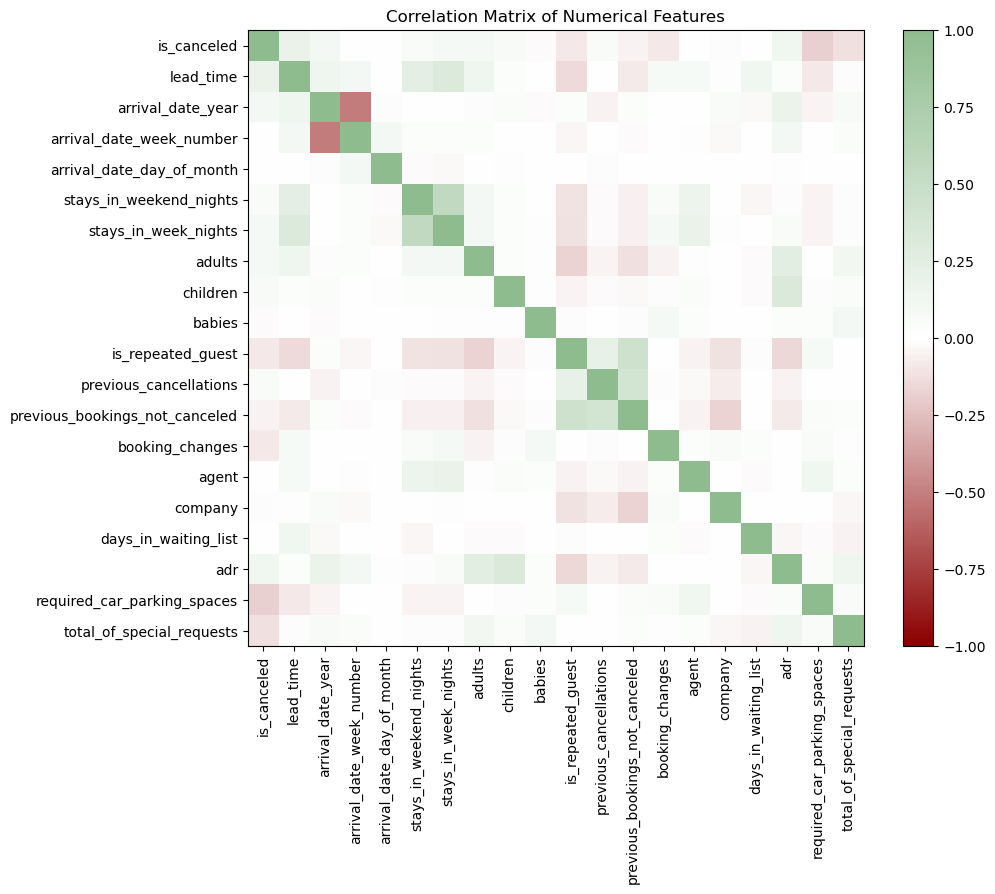

In [5]:
def visualize_data(df: pd.DataFrame) -> None:
    """Generate key EDA plots using matplotlib."""

    # Correlation matrix (some numerical features only)
    import matplotlib.colors as mcolors
    
    plt.figure(figsize=(10, 8))
    corr = df.select_dtypes(include=['int64', 'float64']).corr()
    
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_diverging",
        ["darkred", "white", "darkseagreen"]
    )
    
    plt.imshow(corr, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

visualize_data(df_clean)

# def main():
#     url = "https://github.com/manthangandhi/hotel_cancellation_prediction/raw/refs/heads/main/data/hotel_bookings.csv"
#     df = load_data(url)
#     df_clean = clean_data(df)
#     summarize_data(df_clean)
#     visualize_data(df_clean)


# if __name__ == "__main__":
#     main()

In [2]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("default")
alt.data_transformers.disable_max_rows()
alt.renderers.enable('png')

RendererRegistry.enable('png')

## Question of Interest: 
Can we predict hotel cancellations from booking lead time and different types of guest behaviors, using hotel booking information from the year 2017? And do cancellations differ across hotel type?


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/manthangandhi/hotel_cancellation_prediction/refs/heads/main/data/hotel_bookings.csv')

## Feature Selection

In [4]:
cols_of_interest = [
    "hotel",
    "arrival_date_year",
    "is_canceled", 
    "lead_time",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "total_of_special_requests",
    "is_repeated_guest",
    "deposit_type",
    "reserved_room_type"
]

hotel_data = data[cols_of_interest]

In [5]:
hotel_data.columns.to_list()

['hotel',
 'arrival_date_year',
 'is_canceled',
 'lead_time',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'total_of_special_requests',
 'is_repeated_guest',
 'deposit_type',
 'reserved_room_type']

In [6]:
hotel_data['arrival_date_year'].value_counts()

arrival_date_year
2016    56707
2017    40687
2015    21996
Name: count, dtype: int64

Since the entire dataset is quite large, we'll be focusing on hotel data from the most recent year, the year 2017, to make predictions about hotel cancellations.

In [7]:
data_2017 = hotel_data[hotel_data['arrival_date_year'] == 2017]

In [8]:
#now that we don't need the year column, we can drop it. 
hotel_data_cleaned = data_2017.drop(columns=['arrival_date_year']).dropna()
hotel_data_cleaned

,hotel,is_canceled,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,total_of_special_requests,is_repeated_guest,deposit_type,reserved_room_type
9775,Resort Hotel,1,74,0,0,0,0,0,No Deposit,A
9776,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9777,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9778,Resort Hotel,1,62,0,0,0,1,0,No Deposit,A
9779,Resort Hotel,1,71,0,0,0,1,0,No Deposit,A
...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,0,0,0,0,0,No Deposit,A
119386,City Hotel,0,102,0,0,0,2,0,No Deposit,E
119387,City Hotel,0,34,0,0,0,4,0,No Deposit,D
119388,City Hotel,0,109,0,0,0,0,0,No Deposit,A


## EDA

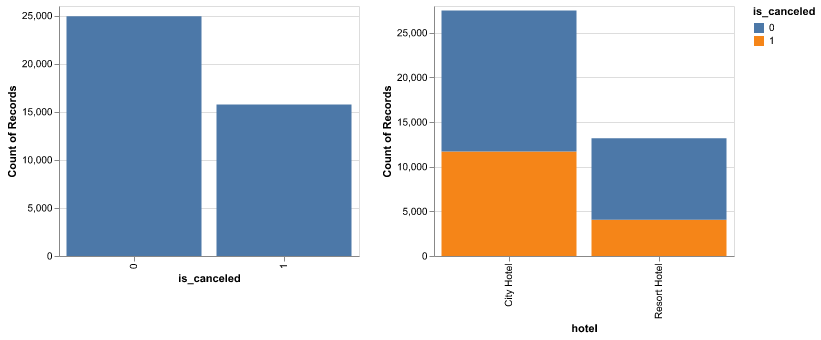

In [9]:
target_dist = alt.Chart(hotel_data_cleaned[['is_canceled', 'hotel']]).mark_bar().encode(
    x='is_canceled:N',
    y='count()',
).properties(
    height=250, 
    width=300
)

target_dist_hotel_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='hotel:N',
    y='count()',
    color='is_canceled:N'
).properties(
    height=250, 
    width=300
)

target_dist | target_dist_hotel_type

As we can see from the plot on the left, there is not a significant class imbalance. The number of cancellations is slightly lower than the number of non cancellations, however, the proportion of cancellations to non cancellations is not extremely different.

The plot on the right shows that there are more cancellations for city hotels compared to resort hotels.

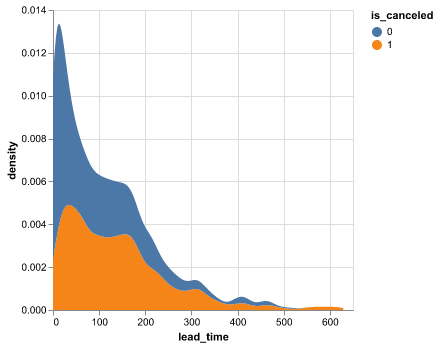

In [10]:
lead_time_plot = alt.Chart(hotel_data_cleaned).transform_density(
    'lead_time',
    groupby= ['is_canceled'],
    as_=['lead_time', 'density'],
).mark_area().encode(
    x="lead_time:Q",
    y='density:Q',
    color='is_canceled:N'
)
lead_time_plot

In the above density plot, we can see that cancelled bookings tend to have much higher lead times compared to bookings made more last minute (shorter lead times), which suggests that lead time could be a promising predictor for hotel cancellations.

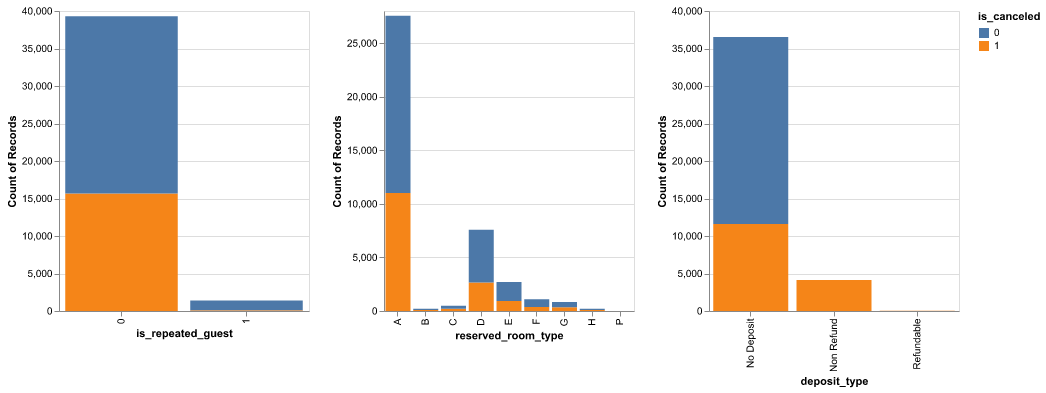

In [11]:
repeated_guest = alt.Chart(hotel_data_cleaned[['is_repeated_guest', 'deposit_type', 'reserved_room_type', 'is_canceled']]).mark_bar().encode(
    x='is_repeated_guest:N', 
    y='count()',
    color='is_canceled:N'
).properties(width=250)

deposit_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='deposit_type:N',
    y='count()',
    color='is_canceled:N'
).properties(width=250)


room_type = alt.Chart(hotel_data_cleaned).mark_bar().encode(
    x='reserved_room_type:N',
    y='count()',
    color='is_canceled:N'
).properties(width=250)

repeated_guest | room_type | deposit_type

We can observe from the plots above that almost all cancellations are happening for new guests. Repeated guests who have booked with the hotel before do not seem to cancel much. In addition, the majoirty of cancellations occur for guests who have booked room type A. Interestingly, guests seem to cancel more when they have not provided a deposit on their booking and some also cancel when their deposit is non refundable.


## Preprocessing + Feature Transformations

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


In [13]:
X = hotel_data_cleaned.drop(columns=['is_canceled'])
y = hotel_data_cleaned["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

num_features = ["lead_time", "previous_cancellations", 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
cat_features = ["reserved_room_type", "deposit_type"]
binary_features = ['is_repeated_guest']

In [14]:
#defining transformers 
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")

In [15]:
preprocessor = make_column_transformer(    
    (num_transformer, num_features),
    ("passthrough", binary_features),   
    (cat_transformer, cat_features)
)

## Training Models (Ashifa)

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Defining three models we are using to test 
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=6, random_state=123)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=123)

# Building the pipelines
pipe_knn = make_pipeline(preprocessor, knn)
pipe_dt = make_pipeline(preprocessor, dt)
pipe_svm = make_pipeline(preprocessor, svm_rbf)

In [17]:
from sklearn.model_selection import cross_val_score

pipelines = {
    "KNN": pipe_knn,
    "DecisionTree": pipe_dt,
    "SVM_RBF": pipe_svm
}

cv_results = {}

#We are using 5-fold CV and comparing F1 scores 
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1")
    cv_results[name] = scores
    print(f"{name}: mean F1 = {scores.mean():.3f} ± {scores.std():.3f}")

KNN: mean F1 = 0.602 ± 0.009
DecisionTree: mean F1 = 0.572 ± 0.010
SVM_RBF: mean F1 = 0.526 ± 0.006


In [18]:
best_pipe = pipe_knn
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

In [20]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Overall accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Test accuracy: 0.733
Confusion matrix:
 [[6453 1078]
 [2186 2490]]


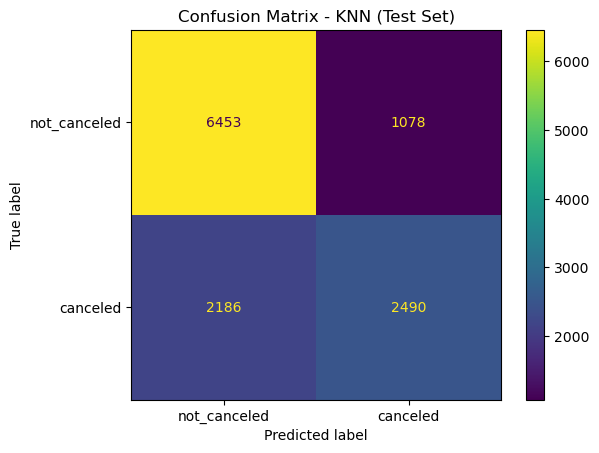

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_disp = ConfusionMatrixDisplay.from_estimator(
    best_pipe,          
    X_test,
    y_test,
    display_labels=["not_canceled", "canceled"],
    values_format="d"   
)

plt.title("Confusion Matrix - KNN (Test Set)")
plt.show()

- make pipeline with preprocessor + 2/3 models (KNN, Decision Tree, SVM RBF)
- carry out cv + compare scores to decide which model is best
- fit best model on training 
- score on test set
- generate confusion matrix (show precision/recall/f1 scores based on scores form the test set)
- another visualization idea: show ROC Curve, precision/recall curve.


# Discussion of Results

With this project, our primary goal was to predict the whether a hotel bookings would eventually end up being cancelled, using information that is available at the time of booking including lead time, deposit type, room type and whether the guest is a repeat customer etc. The idea is that a reasonably accurate model could help hotel businesses flag high-risk bookings and adjust their policies or communication before the stay date.

For the purpose of getting the best model to do this prediction, we compared three classification models using 5-fold cross validation on the training set, with F1 score (for the cancellation class) as the main metric, **K-Nearest Neighbours (KNN, k = 15), Decision Tree (max_depth = 6), and RBF-kernel SVM (C = 1.0, gamma = “scale”).** After scoring their mean F1 scores on the training folds, the F1 score results were: F1 = 0.602 for KNN, F1= 0.57 for Decision Tree and F1=0.526 for RBF SVM. 
KNN clearly performed best on this metric, and also consistently across the folds with the least standard deviations. Because our main concern is to correctly identify cancellations rather than just overall accuracy, we chose **KNN** as the final model for evaluation on the test set.

**Performace on the test set and confusion matrix stats:** 

On the test dat, the KNN model achieved an accuracy of 0.733. Other stats are as follows: 

- Cancellation Precision ≈ 0.70
- Cancellation Recall ≈ 0.53
- Cancellation F1 ≈ 0.60
- Non-Cancellation Precision ≈ 0.75
- Non-Cancellation Recall ≈ 0.86
- Non-Cancellation F1 ≈ 0.80

The averaged F1 is close to 0.70, which is close to what we saw in the cross validation for the cancellation class. This suggests that the model do generally well enough and does not drastically overfit the training data.

If we assume a rough baseline of always predicting “not cancelled”, the model would give an accuracy of 62%. So looking into that, our KNN model improves this by about 73% which also provides a meaningful recall for the cancellation class. Our model leans slightly towards being a bit cautious about over-flagging cancellations (higher position than recall for positive class). But in practice, this is acceptable, as the hotel would want to avoid annoying, loyal and serious guests with extra checks, but it also would be very useful in catching more of these genuinely risky bookings. 

**Limitations to keep in mind when interpreting :**

- **Feature and dataset limitations:** The dataset has restricted us with booking data from only one year - 2017, and also it is taken from a mix for too many countries. This simplifies the problem but may limit how well the model generalizes to other years with different travel patterns or external events. The analysis might differ from location to location and country to country. We used a small, curated set of features thus including more information (such as market segment, distribution channel, length of stay or country) could help the model learn more subtle patterns and improve recall for cancellations.
- **No hyperparameter tuning yet:** We used fixed hyperparameters (e.g., k = 15 for KNN) rather than performing a grid search or randomized search. Systematic tuning could yield a better balance between precision and recall for the cancellation class.
- **Single threshold:** We used the default decision threshold of 0.5. For a real hotel, it might be better to adjust this threshold depending on whether they are more concerned about missed cancellations or about over-flagging guests.

**Overall takeaway:** 

In overall, the KNN model provides a **useful starting point** for predicting hotel booking cancellations. It clearly outperforms a simple majority baseline, correctly identifies most non-cancellations and captures a meaningful portion of actual cancellations. With additional tuning, more features and a more careful treatment of missing values and thresholds, this approach could be developed into a practical decision support tool to help hotels manage overbooking strategies, communicate proactively with high-risk guests and reduce the last minute revenue losses.

# References

Antonio, N., de Almeida, A., & Nunes, L. (2017, December). Predicting hotel bookings cancellation with a machine learning classification model. In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 1049-1054). IEEE.

Antonio, N., De Almeida, A., & Nunes, L. (2019). Big data in hotel revenue management: Exploring cancellation drivers to gain insights into booking cancellation behavior. Cornell Hospitality Quarterly, 60(4), 298-319.

Chen, S., Ngai, E. W. T., Ku, Y., Xu, Z., Gou, X., & Zhang, C. (2023). Prediction of hotel booking cancellations: Integration of machine learning and probability model based on interpretable feature interaction. Decision Support Systems, 170.

Yang, D., & Miao, X. (2024). Predicting hotel booking cancellations using tree-based neural network. PeerJ Computer Science, 10.

Sánchez, E. C., Sánchez-Medina, A. J., & Pellejero, M. (2020). Identifying critical hotel cancellations using artificial intelligence. Tourism Management Perspectives, 35.